## Textual Data Lab

### preparing data

In [1]:
import pandas as pd
df = pd.read_csv('un-general-debates-blueprint.csv.gz')

In [2]:
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [3]:
import nltk
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [4]:
def ngrams(tokens, n=2, sep=' ', stopwords=stopwords):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
           if len([t for t in ngram if t in stopwords])==0]

In [5]:
pipeline1 = [str.lower, tokenize, remove_stop]
pipeline2 = [str.lower, tokenize, ngrams]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [6]:
df['unigram_tokens'] = df['text'].apply(prepare, pipeline=pipeline1)
df['bigram_tokens'] = df['text'].apply(prepare, pipeline=pipeline2)
df.sample(4)

,session,year,country,country_name,speaker,position,text,unigram_tokens,bigram_tokens
3821,51,1996,ITA,Italy,Lamberto Dini,Minister for Foreign Affairs,"﻿On behalf of Italy, I am pleased to\nexpress ...","[behalf, italy, pleased, express, sir, warmest...","[warmest congratulations, general assembly, wi..."
4623,55,2000,TUN,Tunisia,Habib Ben Yahia,Minister for Foreign Affairs,I am\nparticularly pleased to express my congr...,"[particularly, pleased, express, congratulatio...","[particularly pleased, fifty-fifth session, ge..."
3747,51,1996,ATG,Antigua and Barbuda,Mr. Lewis,UN Representative,﻿It is with profound\npleasure that I salute t...,"[profound, pleasure, salute, president, diplom...","[profound pleasure, one worthy, fifty-first se..."
6747,67,2012,BGD,Bangladesh,Sheikh Hasina,Prime Minister,﻿I warmly\ncongratulate Mr. Jeremić on his ele...,"[warmly, congratulate, mr, jeremić, election, ...","[warmly congratulate, congratulate mr, mr jere..."


### 1. Find the top 10 word bigram from UN General Debates of years 1970 –1990 and compare with those of years 1990 –the latest (remove stopwordsfirst)

In [7]:
from collections import Counter
def count_words(df, column='bigram_tokens', preprocess=None, min_freq = 2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)    
    counter = Counter()
    df[column].map(update)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'token'    
    return freq_df.sort_values('freq', ascending=False)

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Bigram Token'),
 Text(0.5, 1.0, 'Top 10 Words Bigram 1970 –1990')]

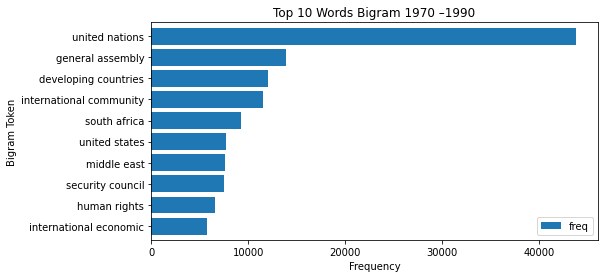

In [8]:
text1 = df.query("year>=1970 and year<=1990")
freq_df1 = count_words(text1)

ax = freq_df1.sort_values('freq', ascending=False).head(10).plot(kind='barh', width=0.8, figsize=(8,4))
ax.invert_yaxis() # เปลี่ยนให้เรียงจากมากไปน้อย
ax.set(xlabel='Frequency', ylabel='Bigram Token', title='Top 10 Words Bigram 1970 –1990')

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Bigram Token'),
 Text(0.5, 1.0, 'Top 10 Words Bigram 1990 –2015')]

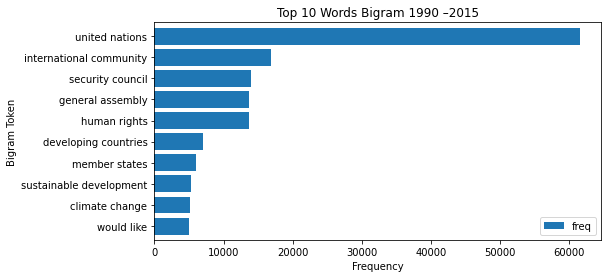

In [9]:
text2 = df.query("year>=1990 and year<=2015")
freq_df2 = count_words(text2)

ax = freq_df2.sort_values('freq', ascending=False).head(10).plot(kind='barh', width=0.8, figsize=(8,4))
ax.invert_yaxis() # เปลี่ยนให้เรียงจากมากไปน้อย
ax.set(xlabel='Frequency', ylabel='Bigram Token', title='Top 10 Words Bigram 1990 –2015')

### 2. Create a bigram word cloud of the UN General Debates dataset of years 1970 –1990 and 1990 to the latest (remove stopwordsfirst)

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)    
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)    
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

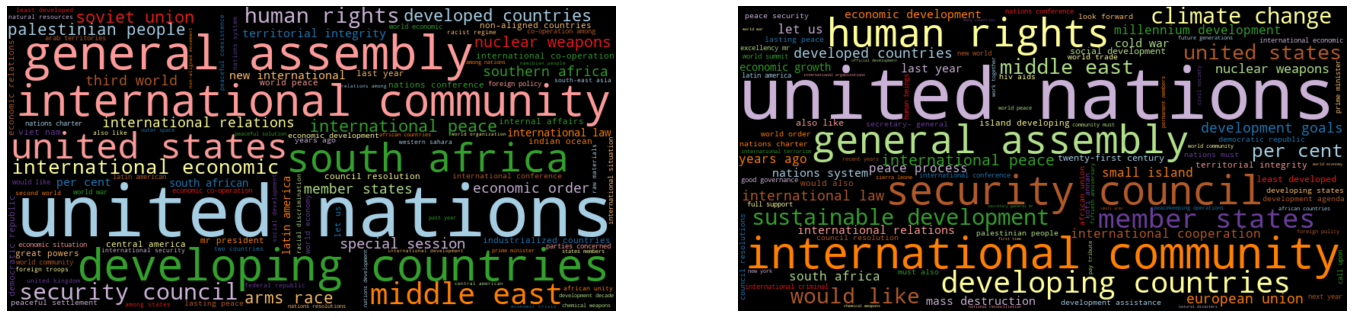

In [11]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)###
wordcloud(freq_df1['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df2['freq'], max_words=100)
#plt.tight_layout()###

### 3. Create a trend graph showing the bigram and word trend of “climate change”, “global warming”, “wars” and 3 others of your choices

In [12]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]    
    return freq_df.groupby(by).sum().sort_values(by)

In [13]:
unigram_keywords = ['japan', 'wars']
bigram_keywords = ['narcotic drugs','soviet union','climate change', 'global warming']

freq_df3 = count_keywords_by(df, by='year', keywords=unigram_keywords, column='unigram_tokens')
freq_df4 = count_keywords_by(df, by='year', keywords=bigram_keywords, column='bigram_tokens')

<AxesSubplot:xlabel='year'>

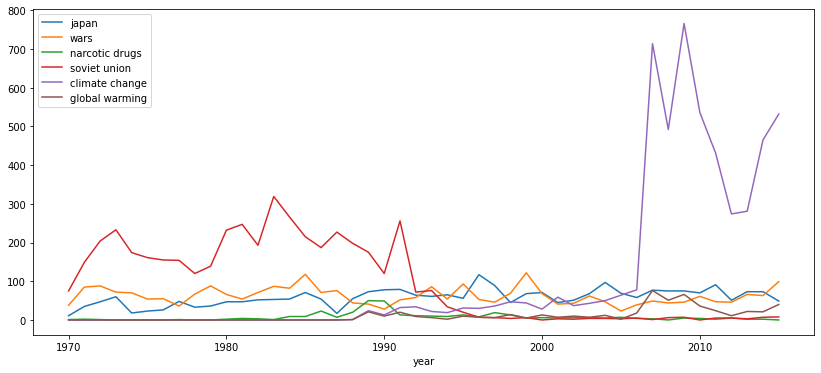

In [14]:
ax = freq_df3.plot(kind='line', figsize=(14,6))
freq_df4.plot(ax=ax)